## Import

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.distributions.normal import Normal
from torch import nn, optim  
from torch.utils.data import DataLoader, Dataset     
import torch.nn.functional as F  
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from torch.nn.parameter import Parameter


from sklearn.model_selection import train_test_split

from tqdm import tqdm
import random
import copy

import copy

In [2]:
# data import
df_s = pd.read_csv('df_s_concave_convex.csv')
df_s_true = pd.read_csv('df_s_true_concave_convex.csv')
df_t = pd.read_csv('df_t_concave_convex.csv')
df_t_true = pd.read_csv('df_t_true_concave_convex.csv')
df_t_labeled = pd.read_csv('df_t_labeled_true_concave_convex.csv')
for i in range(10):
    exec(f"df_t{i} = pd.read_csv('df_t{i}_concave_convex.csv')")

In [3]:
# data preprocessing
x_s = torch.tensor(df_s['X']).reshape(-1,1).type(torch.float32)
x_t =torch.tensor(df_t['X']).reshape(-1,1).type(torch.float32)
x_t_labeled =torch.tensor(df_t_labeled['X']).reshape(-1,1).type(torch.float32)
y_s = torch.tensor(df_s['Y']).reshape(-1,1).type(torch.float32)
y_t =torch.tensor(df_t['Y']).reshape(-1,1).type(torch.float32)
y_t_labeled =torch.tensor(df_t_labeled['Y']).reshape(-1,1).type(torch.float32)
y_s_true = torch.tensor(df_s_true['Y']).reshape(-1,1).type(torch.float32)
y_t_true =torch.tensor(df_t_true['Y']).reshape(-1,1).type(torch.float32)
for i in range(10):
    exec(f"x_t{i} = torch.tensor(df_t{i}['X']).reshape(-1,1).type(torch.float32)")
    exec(f"y_t{i} = copy.deepcopy(y_s)")
x_t10 = copy.deepcopy(x_s)
y_t10 = copy.deepcopy(y_s)

## MAML

In [4]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(1, 256)
        self.relu = nn.ReLU()
        self.h2 = nn.Linear(256, 256)
        self.h3 = nn.Linear(256, 256)
        self.reg = nn.Linear(256, 1)
        self.drop1 = nn.Dropout()
        self.drop2 = nn.Dropout()
        
    def forward(self, x):
        x = self.h1(x)
        x = self.relu(x)
        x = self.h2(x)
        x = self.relu(x)
        x = self.h3(x)
        x = self.relu(x)
        x = self.reg(x)

        return x

### Meta-Learning

In [5]:
parent_model = MLP()
optimizer = optim.Adam(parent_model.parameters(), lr=0.001)
domain_num = 10 + 1
batch_domain = 3
batch_num = 20

for outer_epoch in range(10000):
    parent_model.eval()
    
    batch_domain_list = random.sample(range(domain_num), batch_domain)
    batch_data_list = random.sample(range(len(x_t0)), batch_num*2)
    batch_train_data_list = batch_data_list[:10]
    batch_val_data_list = batch_data_list[10:]
    for batch_domain_idx in batch_domain_list:
        exec(f"child_model{batch_domain_idx} = copy.deepcopy(parent_model)")
        exec(f"optimizer{batch_domain_idx} = optim.Adam(child_model{batch_domain_idx}.parameters(), lr = 0.001)")
        exec(f"child_model{batch_domain_idx}.train()")
        exec(f"optimizer{batch_domain_idx}.zero_grad()")
        for inner_epoch in range(10):
            exec(f"temp_loss = torch.nn.functional.mse_loss(child_model{batch_domain_idx}(x_t{batch_domain_idx}[batch_train_data_list]), x_s[batch_train_data_list])")
            temp_loss.backward()
            exec(f"optimizer{batch_domain_idx}.step()")
    
    parent_model.train()
    optimizer.zero_grad()
    loss = 0
    for batch_domain_idx in batch_domain_list:
        exec(f"loss += torch.nn.functional.mse_loss(child_model{batch_domain_idx}(x_t{batch_domain_idx}[batch_val_data_list]), x_s[batch_val_data_list])")
    loss /= batch_domain
    loss.backward()
    optimizer.step()

    if outer_epoch % 100 == 99:
        print(f"epoch : {outer_epoch}, train loss : {loss.detach().item()}")

epoch : 99, train loss : 556.365234375
epoch : 199, train loss : 62.560821533203125
epoch : 299, train loss : 2880.6904296875
epoch : 399, train loss : 682.6190185546875
epoch : 499, train loss : 25173.287109375
epoch : 599, train loss : 373.0328369140625
epoch : 699, train loss : 83.37415313720703
epoch : 799, train loss : 245.4158477783203
epoch : 899, train loss : 196.8285675048828
epoch : 999, train loss : 208.8768768310547
epoch : 1099, train loss : 334.149169921875
epoch : 1199, train loss : 389.2554931640625
epoch : 1299, train loss : 315.6070251464844
epoch : 1399, train loss : 631.6807250976562
epoch : 1499, train loss : 591.1975708007812
epoch : 1599, train loss : 14289.0859375
epoch : 1699, train loss : 95.71753692626953
epoch : 1799, train loss : 7732.15234375
epoch : 1899, train loss : 186.5297393798828
epoch : 1999, train loss : 358.5430603027344
epoch : 2099, train loss : 436.2274475097656
epoch : 2199, train loss : 283.68450927734375
epoch : 2299, train loss : 1510.9232

### Meta-Inference

In [6]:
target_model = copy.deepcopy(parent_model)
target_model.train()
target_optimizer = optim.Adam(target_model.parameters(), lr=0.001)
train_loss_list = []
test_loss_list = []
true_test_loss_list = []
model_list = []
for i in range(2000):
    model_list.append(copy.deepcopy(target_model))
    target_model.eval()
    target_model(x_t)
    test_loss_list.append(torch.nn.functional.mse_loss(target_model(x_t), y_t).detach().item())
    true_test_loss_list.append(torch.nn.functional.mse_loss(target_model(x_t), y_t_true).detach().item())

    target_model.train()
    target_optimizer.zero_grad()
    train_loss = torch.nn.functional.mse_loss(target_model(x_t_labeled), y_t_labeled)
    train_loss.backward()
    target_optimizer.step()
    train_loss_list.append(train_loss.detach().item())

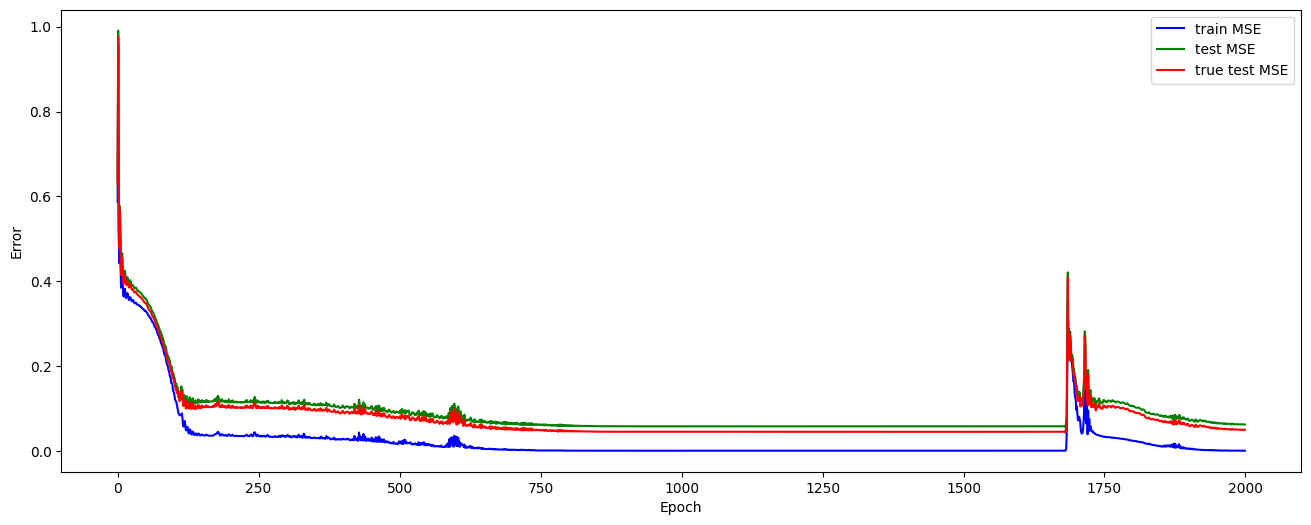

In [7]:
plt.figure(figsize=(16,6))
plt.plot(range(len(train_loss_list)), train_loss_list, c='blue', label='train MSE', zorder=1)
plt.plot(range(len(train_loss_list)), test_loss_list, c='green', label='test MSE', zorder=2)
plt.plot(range(len(train_loss_list)), true_test_loss_list, c='red', label='true test MSE', zorder=3)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.show()

test mse : 0.061891525983810425, denoised test mse : 0.04932315647602081


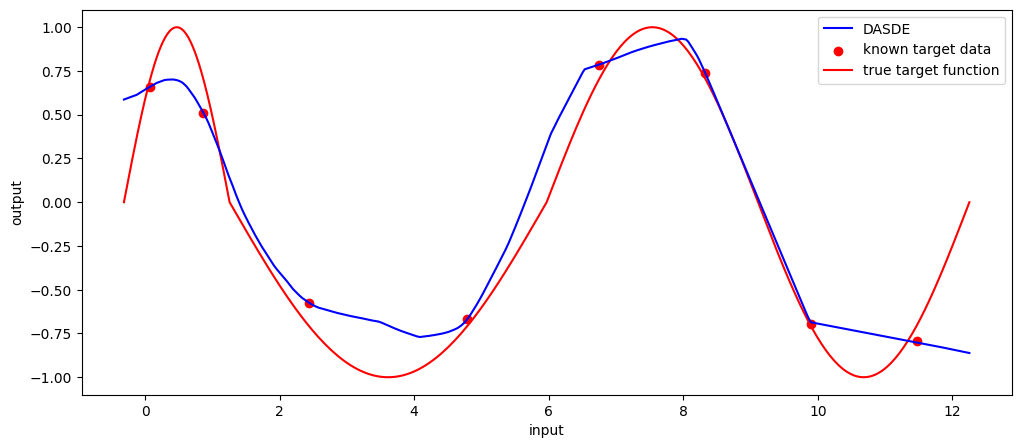

In [8]:
plt.figure(figsize=(12,5))
plt.plot(x_t, target_model(x_t).detach().numpy(), c='blue', label='DASDE', zorder=2)
plt.scatter(x_t_labeled, y_t_labeled, c='red', label='known target data', zorder=1)
plt.plot(x_t, y_t_true, c='red', label='true target function', zorder=1)
plt.xlabel('input')
plt.ylabel('output')
plt.legend()
print(f"test mse : {test_loss_list[-1]}, denoised test mse : {true_test_loss_list[-1]}")